In [213]:
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import tqdm
import csv
from scipy.stats import loguniform
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [214]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [215]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


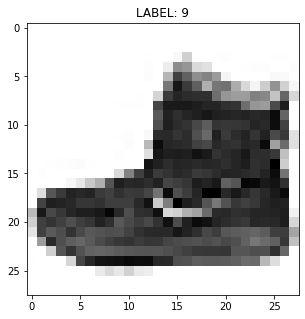

In [216]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(5,5))
plt.imshow(image, cmap='Greys')
plt.title(f"LABEL: {label}")
plt.show()
#fig.savefig("report/cls_imgs/example0.pdf", transparent = True, bbox_inches = 'tight',
 #   pad_inches = 0)
#print(f"SAMPLE AT INDEX {sample_index}")
#print(f"LABEL: {label}")

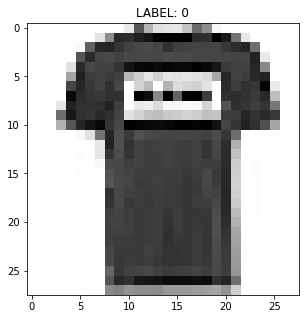

In [217]:
sample_index = 1
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(5,5))
plt.imshow(image, cmap='Greys')
plt.title(f"LABEL: {label}")
plt.show()
#fig.savefig("report/cls_imgs/example1.pdf", transparent = True, bbox_inches = 'tight',
 #   pad_inches = 0)
#print(f"SAMPLE AT INDEX {sample_index}")
#print(f"LABEL: {label}")

In [218]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


In [219]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return F.log_softmax(x,dim=1)

In [283]:
class Net(nn.Module):

    def __init__(self, dropout_conv=0):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)

        self.max_pool = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)

        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.act = nn.ReLU()
        self.dropout_conv = nn.Dropout(dropout_conv)
        #self.mpool = nn.MaxPool2d(2, 2)

    def forward(self, x, stop1 = False):
        x = self.conv1(x)
        x = self.act(x)
        if stop1: return x
        x = self.max_pool(x)
        x = self.dropout_conv(x)
        
        x = self.conv2(x)
        x = self.act(x)
        
        x = self.max_pool(x)
        x = self.dropout_conv(x)

        x = x.view(-1, 1024)
    
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout_conv(x)
        
        x = self.fc2(x)

        return x

In [221]:
class img_dataset(torch.utils.data.Dataset):
   
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:     
            x = self.transform(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  # image
            
        y = self.dataset[index][1]   # label      
        return x, y

    def __len__(self):
        return len(self.dataset) 

In [222]:

composed_transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

#---Train/Validation split---#
#n_samples = len(train_dataset)
#n_training = int(0.8 * n_samples) #80%-20% split

#train_dataset_loop, val_dataset = torch.utils.data.random_split(train_dataset, [n_training, n_samples-n_training]) 

train_dataset = img_dataset(train_dataset, transform=composed_transform)
test_dataset = img_dataset(test_dataset, transform=composed_transform)

In [223]:
def train_epoch(net, train_dataloader, loss_fn, optimizer):
    train_loss = []
    net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
        
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    return train_loss
    #print(f"AVERAGE TRAIN LOSS: {train_loss}")

In [224]:
def test_epoch(net, val_dataloader, loss_fn):
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    return np.mean(val_loss)

def training_loop_cv_1(train_dataset, hy, nfolds = 4):
    # Check if the GPU is available
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f"Training device: {device}")
    net = Net()
    net.to(device)

    # Define the K-fold Cross Validator
    num_folds = nfolds
    kfold = KFold(n_splits=num_folds, shuffle=True)

    num_epochs  = hy["n_epochs"]
    train_log_folds = np.zeros((num_folds, num_epochs))
    val_log_folds   = np.zeros((num_folds, num_epochs))

    for f, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        #print('####################################################################')
        #print(f'# FOLD {f+1}')
        #print('####################################################################\n')

        train_subsampler = SubsetRandomSampler(train_idx)
        val_subsampler   = SubsetRandomSampler(val_idx)
        
        train_dataloader = DataLoader(train_dataset, batch_size=hy["batch_size"], sampler=train_subsampler)
        val_dataloader   = DataLoader(train_dataset, batch_size=hy["batch_size"], sampler=val_subsampler)
        
        # Define the loss function
        loss_fn = nn.CrossEntropyLoss()

        # Define the optimizer
        if   hy["opt"] == "Adam":    optimizer = optim.Adam(net.parameters(),  lr = hy["lr"], weight_decay= hy["l2"])
        elif hy["opt"] == "RMSprop": optimizer = optim.RMSprop(net.parameters(), lr = hy["lr"], weight_decay= hy["l2"])
        elif hy["opt"] == "SGD":     optimizer = optim.SGD(net.parameters(),     lr = hy["lr"], weight_decay= hy["l2"])

        train_loss_log = np.zeros(num_epochs)
        val_loss_log = np.zeros(num_epochs)

        for epoch_num in range(num_epochs):
            train_loss = train_epoch(net, train_dataloader, loss_fn, optimizer)
            train_loss_log[epoch_num] = train_loss

            val_loss = test_epoch(net, val_dataloader, loss_fn)
            val_loss_log[epoch_num] = val_loss
        
        train_log_folds[f] = train_loss_log
        val_log_folds[f]   = val_loss_log
        
    return np.mean(train_log_folds, axis = 0), np.mean(val_log_folds, axis = 0), net

In [225]:
def random_hyperparameters():

    regularization_type = np.random.choice(['none', 'l2'])
    regularization_strength = 0.
    
    if regularization_type == 'l2': regularization_strength = loguniform.rvs(1e-5, 1e-1)
    elif regularization_type == 'dropout': regularization_strength = loguniform.rvs(1e-4, 1e-1)

    hyperparameters = {
        'n_epochs': 8,
        'batch_size': np.random.choice([64, 128, 256]).tolist(),
        'lr': loguniform.rvs(1e-4, 1e-1),
        'regularization_type' : regularization_type,
        'regularization_strength' : regularization_strength,
        'l2': regularization_strength if regularization_type == 'l2' else 0.,
        'dropout': regularization_strength if regularization_type == 'dropout' else 0.,
        'opt' : np.random.choice(['Adam', 'RMSprop', 'SGD'])
    }
    return hyperparameters

In [229]:
def training_loop(train_dataset, hy):
    # Check if the GPU is available
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f"Training device: {device}")
    net = Net(dropout_conv=hy['dropout'])
    net.to(device)

    
    num_epochs  = hy["n_epochs"]
    tot_size = len(train_dataset)
    train_size = int(tot_size*0.8)
    val_size = tot_size - train_size
    print(val_size)
    train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    #print(train_size, val_size)
    train_dataloader = DataLoader(train_set, batch_size=hy["batch_size"], shuffle=True)#, num_workers=2, pin_memory = True)
    val_dataloader  = DataLoader(val_set,  batch_size=len(val_set), shuffle=False)#, num_workers=2, pin_memory = True)
    
    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # Define the optimizer
    if hy["opt"] == "Adam":      optimizer = optim.Adam(net.parameters(),    lr = hy["lr"], weight_decay= hy["l2"])
    elif hy["opt"] == "RMSprop": optimizer = optim.RMSprop(net.parameters(), lr = hy["lr"], weight_decay= hy["l2"])
    elif hy["opt"] == "SGD":     optimizer = optim.SGD(net.parameters(),     lr = hy["lr"], weight_decay= hy["l2"])
    
    train_loss_log = np.zeros(num_epochs)
    val_loss_log = np.zeros(num_epochs)
    
    for epoch_num in range(num_epochs):
            train_loss = train_epoch(net, train_dataloader, loss_fn, optimizer)
            train_loss_log[epoch_num] = train_loss

            val_loss = test_epoch(net, val_dataloader, loss_fn)
            val_loss_log[epoch_num] = val_loss
            print("#########")
            print("Epoch", epoch_num+1)
            print("#########")
            print("Train loss:", train_loss)
            print("Val loss:", val_loss)
            
    return train_loss_log, val_loss_log, net

In [230]:
niter = 20
df = pd.DataFrame(columns = ["batch_size", "lr", "regularization_type"
                            , "regularization_strength", "l2", "dropout", "opt", "mean_train_loss", "mean_val_loss"], index = range(1,niter+1))

for it in range(1, niter+1):
    r_hy = random_hyperparameters()
    df.loc[it] = r_hy
    loss, val, _ = training_loop(train_dataset, r_hy)
    df.loc[it, "mean_train_loss"] = np.mean(loss, dtype = np.float32)
    df.loc[it, "mean_val_loss"] = np.mean(val, dtype = np.float32)
    print("Trial", it, "done!")

df

Training device: cuda
12000


KeyboardInterrupt: 

In [33]:
df = df.astype({"mean_val_loss":float})
df.nsmallest(10, 'mean_val_loss')

,batch_size,lr,regularization_type,regularization_strength,l2,dropout,opt,mean_train_loss,mean_val_loss
1,64,0.000299,none,0.0,0.0,0.0,Adam,0.332628,0.322935
3,128,0.00372,l2,0.005707,0.005707,0.0,Adam,0.381103,0.390986
8,128,0.000133,l2,0.000065,0.000065,0.0,RMSprop,0.432291,0.402641
14,256,0.000249,l2,0.000079,0.000079,0.0,RMSprop,0.415583,0.408414
12,128,0.002076,l2,0.012985,0.012985,0.0,Adam,0.434098,0.428048
7,64,0.010155,none,0.0,0.0,0.0,Adam,0.427678,0.442581
9,64,0.007033,none,0.0,0.0,0.0,RMSprop,0.666741,0.475521
5,256,0.024447,l2,0.000986,0.000986,0.0,Adam,0.563925,0.495363
2,256,0.025817,none,0.0,0.0,0.0,Adam,0.566641,0.495601
11,256,0.029011,none,0.0,0.0,0.0,SGD,0.621458,0.564047


In [284]:
hyperparameters = {
    'n_epochs': 100,
    'batch_size': 128,
    'lr': 0.0002,
    'l2': 0,
    'opt': 'Adam',
    'dropout': 0.3
}

In [285]:
final_loss_train, final_loss_val, net = training_loop(train_dataset, hyperparameters)

Training device: cuda
12000
#########
Epoch 1
#########
Train loss: 0.9322631
Val loss: 0.54654485
#########
Epoch 2
#########
Train loss: 0.5798603
Val loss: 0.45638427
#########
Epoch 3
#########
Train loss: 0.50216997
Val loss: 0.40351492
#########
Epoch 4
#########
Train loss: 0.4583602
Val loss: 0.37485197
#########
Epoch 5
#########
Train loss: 0.4263318
Val loss: 0.35232666
#########
Epoch 6
#########
Train loss: 0.4068041
Val loss: 0.33192235
#########
Epoch 7
#########
Train loss: 0.38456494
Val loss: 0.3218479
#########
Epoch 8
#########
Train loss: 0.37238622
Val loss: 0.313916
#########
Epoch 9
#########
Train loss: 0.3605568
Val loss: 0.30673695
#########
Epoch 10
#########
Train loss: 0.35112435
Val loss: 0.2922252
#########
Epoch 11
#########
Train loss: 0.3410015
Val loss: 0.29024017
#########
Epoch 12
#########
Train loss: 0.33241916
Val loss: 0.28797302
#########
Epoch 13
#########
Train loss: 0.3241198
Val loss: 0.27740353
#########
Epoch 14
#########
Train loss: 0.3

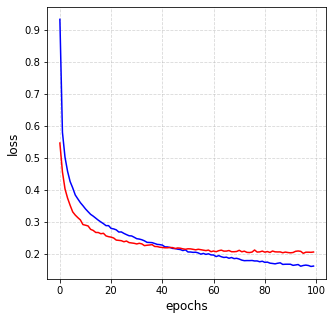

In [286]:
#train_folds_mean = np.mean(train_folds, axis = 0)
#val_folds_mean = np.mean(val_folds, axis = 0)

size = 12
fig = plt.figure(figsize = (5,5))
plt.plot(final_loss_train, color = "blue")
plt.plot(final_loss_val, color = "red")
plt.xlabel("epochs", fontsize = size)
plt.ylabel("loss", fontsize = size)
#plt.legend(fontsize = size)
plt.grid(linestyle = "--", alpha = 0.5)
plt.show()
fig.savefig("class_images/class_train.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

In [287]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
print(net_state_dict.keys())
# Save the state dict to a file
torch.save(net_state_dict, 'net_parameters.torch')

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


def test_epoch(net, val_dataloader, loss_fn):

In [288]:
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
loss_fn = nn.CrossEntropyLoss()

In [289]:
labels = []
outputs = []
net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        labels.append(label_batch)
        # Forward pass
        out = net(x_batch)
        outputs.append(out)
        # Compute loss
        loss = loss_fn(out, label_batch)

        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        test_loss = loss_batch

In [290]:
print(test_loss)

0.23073874


In [291]:
outputs = torch.cat(outputs)
labels = torch.cat(labels)
outputs = outputs.detach().cpu().numpy()
labels = labels.detach().cpu().numpy()

predicted_labels = [outputs[i].argmax() for i in range(len(outputs))]
diffs = np.array([predicted_labels[i]-labels[i] for i in range(len(outputs))])
wrong = np.count_nonzero(diffs) 
test_accuracy = 1 - wrong/len(outputs)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.9185


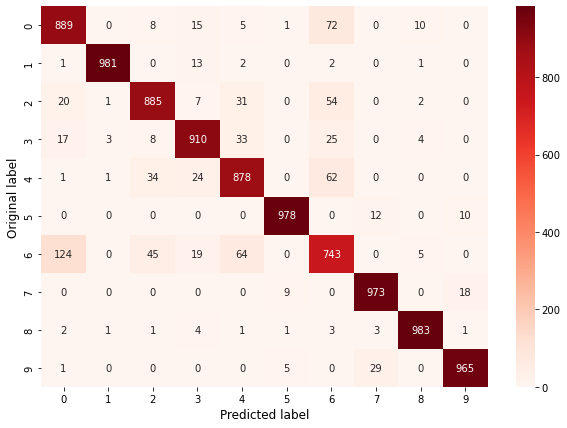

In [292]:
### Confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

# Evaluate confusion matrix
cm = confusion_matrix(labels, predicted_labels)
# Show the confusion matrix
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, cmap='Reds', fmt='d', annot=True)
plt.ylabel('Original label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig('class_images/cmap.pdf', transparent = True, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

## Example of misclassified samples

In [293]:
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False, num_workers = 2, pin_memory = 2)
images, labels = next(iter(train_dataloader))

In [294]:
idx0 = np.where(labels.numpy() == 0)[0][0]
idx7 = np.where(labels.numpy() == 6)[0][0]

In [295]:
train_dataset_example = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)

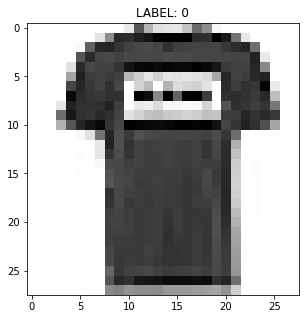

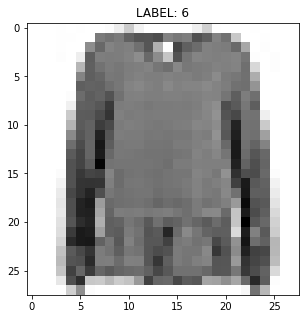

In [296]:
image0 = train_dataset_example[idx0][0]
label0 = train_dataset_example[idx0][1]
image7 = train_dataset_example[idx7][0]
label7 = train_dataset_example[idx7][1]


fig = plt.figure(figsize=(5,5))
plt.imshow(image0, cmap='Greys')
plt.title(f"LABEL: {label0}")
fig = plt.figure(figsize=(10,5))
plt.imshow(image7, cmap='Greys')
plt.title(f"LABEL: {label7}")
plt.show()

In [297]:
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (act): ReLU()
  (dropout_conv): Dropout(p=0.3, inplace=False)
  (mpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

## Plot hists and filters

In [319]:
# First convolutional layer
conv1_w = net.conv1.weight.data.cpu().numpy() 
conv1_b = net.conv1.bias.data.cpu().numpy() 

# Second convolutional layer
conv2_w = net.conv2.weight.data.cpu().numpy()
conv2_b = net.conv2.bias.data.cpu().numpy() 

# First hidden layer
hid1_w = net.fc1.weight.data.cpu().numpy() 
hid1_b = net.fc1.bias.data.cpu().numpy() 

# Second hidden layer
hid2_w = net.fc2.weight.data.cpu().numpy()
hid2_b = net.fc2.bias.data.cpu().numpy()

In [301]:
image_sample = DataLoader(test_dataset, batch_size=1, shuffle=False) 
with torch.no_grad(): 
    for sample_batched in (image_sample):
        x_batch = sample_batched[0].to(device)
        out = net.forward(x_batch, stop1 = True)
        out = out.cpu().numpy()
        break

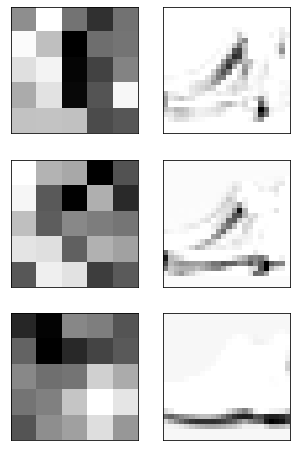

In [314]:
fig, axs = plt.subplots(3, 2, figsize=(5,8))
axs = axs.flatten()
for i in range(0, 6, 2):
    axs[i].imshow(conv1_w[i, 0, :, :], cmap='Greys')
    axs[i+1].imshow(out[0, i], cmap='Greys')
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i+1].set_yticks([])
    axs[i+1].set_xticks([])
plt.show()
fig.savefig("class_images/kernel_visual.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)


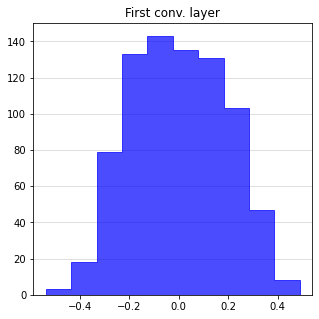

In [332]:
fig = plt.figure(figsize = (5,5))
plt.hist(conv1_w.flatten(), histtype = "step", color = "blue", fill = True, alpha = 0.7)
plt.grid(axis = "y", alpha = 0.5)
plt.title("First conv. layer", size = 12)
fig.savefig("class_images/conv1_hist.pdf", transparent = True,  bbox_inches = 'tight',
    pad_inches = 0)

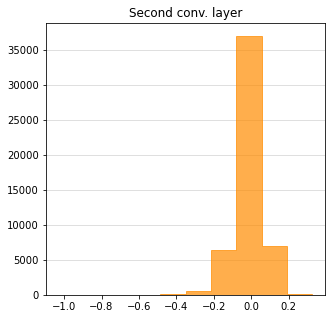

In [333]:
fig = plt.figure(figsize = (5,5))
plt.hist(conv2_w.flatten(), histtype = "step", color = "darkorange", fill = True, alpha = 0.7)
plt.grid(axis = "y", alpha = 0.5)
plt.title("Second conv. layer", size = 12)
fig.savefig("class_images/conv2_hist.pdf", transparent = True,  bbox_inches = 'tight',
    pad_inches = 0)

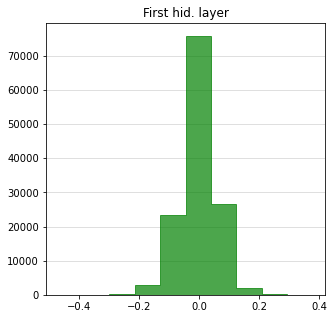

In [334]:
fig = plt.figure(figsize = (5,5))
plt.hist(hid1_w.flatten(), histtype = "step", color = "green", fill = True, alpha = 0.7)
plt.grid(axis = "y", alpha = 0.5)
plt.title("First hid. layer", size = 12)
fig.savefig("class_images/hid1_hist.pdf", transparent = True,  bbox_inches = 'tight',
    pad_inches = 0)

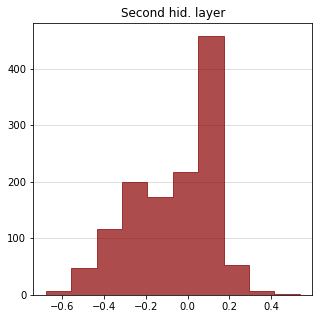

In [337]:
fig = plt.figure(figsize = (5,5))
plt.hist(hid2_w.flatten(), histtype = "step", color = "darkred", fill = True, alpha = 0.7)
plt.grid(axis = "y", alpha = 0.5)
plt.title("Second hid. layer", size = 12)
fig.savefig("class_images/hid2_hist.pdf", transparent = True,  bbox_inches = 'tight',
    pad_inches = 0)